In [59]:
import os
import glob
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from orca.transform import imaging, peeling, dada2ms
from orca.metadata.pathsmanagers import OfflinePathsManager
from astropy.io import fits
import casatools as tools

In [6]:
age = 1 # hours
duration = 13 # seconds
spw = '21'  # 

In [23]:
now = datetime.now()
start_time = now.replace(hour=now.hour-age)
end_time = start_time + timedelta(seconds=duration)

In [8]:
buffer = '7day_buffer'  # choose a buffer

#outdir = '/lustre/claw/{0}'.format(start_time.strftime("%y%m%d"))
outdir = '/lustre/claw/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [9]:
pm = OfflinePathsManager(utc_times_txt_path='/lustre/data/7day_buffer/utc_times.txt', 
                         dadafile_dir='/lustre/data/{0}'.format(buffer), 
                         msfile_dir=outdir,
                         bcal_dir='/lustre/mmanders/bufferdata/hourly/BCAL_stripe3',
                         flag_npy_path='/home/yuping/100-hr-a-priori-flags/20191125-consolidated-flags/20191125-consolidated-flags.npy')

In [37]:
for time in pm.utc_times_mapping: 
    if start_time <= time < end_time:
        print("Converting to MS for time {0}, spw {1}".format(time, spw))
        dada2ms.run_dada2ms(dada_file=pm.get_dada_path(spw, time), out_ms=pm.get_ms_path(time, spw), gaintable=pm.get_gaintable_path(spw)) 
        msfiles = glob.glob(pm.msfile_dir + start_time.strftime("%Y-%m-%d") + '/*/*/*ms') 
        print("Iterating over msfiles: ", msfiles)
        for msfile in msfiles: 
            print("\t Peel and image ", msfile)
            peeling.peel_with_ttcal(msfile, '/home/claw/code/calim-pipeline-phase2/sources.json') 
            imaging.make_image([msfile], date_times_string=start_time.strftime("%Y-%m-%d"),
                               out_dir=pm.msfile_dir + start_time.strftime("%Y-%m-%d"))

Time 2019-12-09 15:27:27
msfiles:  ['/lustre/claw/2019-12-09/hh=15/2019-12-09T15:27:27/21_2019-12-09T15:27:27.ms']
msfile:  /lustre/claw/2019-12-09/hh=15/2019-12-09T15:27:27/21_2019-12-09T15:27:27.ms


In [46]:
fitsfile = pm.msfile_dir + start_time.strftime("%Y-%m-%d") + '/' + start_time.strftime("%Y-%m-%d") + '-image.fits'
data = fits.getdata(fitsfile).squeeze()

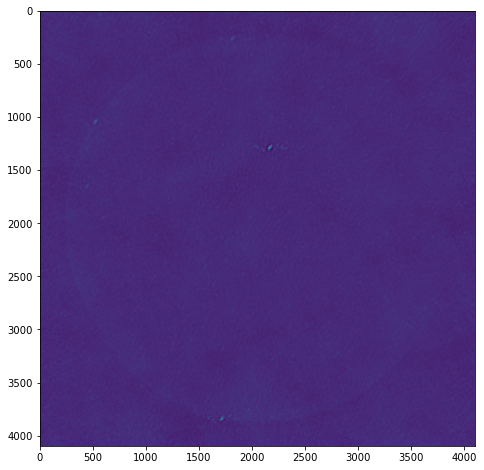

In [55]:
fig = plt.figure(figsize=(10,8))
plt.imshow(data)

In [62]:
ms = tools.ms()
ms.open(msfile)
ms.summary()
getdata = ms.getdata(['data', 'corrected_data', 'data_desc_id'], ifraxis=True)

In [64]:
getdata['data'].shape

(4, 109, 32896)